<a href="https://colab.research.google.com/github/Rohanrathod7/my-ml-labs/blob/main/19_Feature_Engineering_for_NLP_in_Python/02_Text_preprocessing%2C_POS_tagging_and_NER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 4. Customizing spaCy Models


Explore multiple real-world use cases where spaCy models may fail and learn how to train them further to improve model performance. You’ll be introduced to spaCy training steps and understand how to train an existing spaCy model or from scratch, and evaluate the model at the inference time.

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import datetime as dt
# Import confusion matrix and train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import Ridge, Lasso, LogisticRegression, LinearRegression
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier

url = "https://raw.githubusercontent.com/Rohanrathod7/my-ml-labs/main/15_Hyperparameter_Tuning_in_Python/Dataset/results_df.csv"
# Read the CSV file
# Apply pd.to_numeric only to relevant columns, excluding 'text'
results_df = pd.read_csv(url)


display(results_df.head())

,max_depth,min_samples_leaf,learn_rate,accuracy
0,4,16,0.624362,95
1,10,14,0.477450,97
2,7,14,0.050067,96
3,5,12,0.023356,96
4,6,12,0.771275,97


In [ ]:
!python3 pip install spacy
!python3 -m spacy download en_core_web_sm

python3: can't open file '/content/pip': [Errno 2] No such file or directory
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 94.7 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
# Load en_core_web_sm and create an nlp object
import spacy
nlp = spacy.load("en_core_web_sm")

**Training spaCy models**  
spaCy models go a long way for general NLP use cases such as splitting a document into sentences, understanding sentence syntax, and extracting named entities. However, sometimes you seek to train a spaCy model.

When do you need to train a spaCy model? Please select all options that apply.

    -> The accuracy of the spaCy model on your data is unacceptably low.
    
    You can train a spaCy model further whenever it does not perform well on your data or does not include many of the labels in your specific domain.

**Model performance on your data**  
In this exercise, you will practice evaluating an existing model on your data. In this case, the aim is to examine model performance on a specific entity label, PRODUCT. If a model can accurately classify a large percentage of PRODUCT entities (e.g. more than 75%), you do not need to train the model on examples of PRODUCT entities, otherwise, you should consider training the model to improve its performance on PRODUCT entity prediction.

You'll use two reviews from the Amazon Fine Food Reviews dataset for this exercise. You can access these reviews by using the texts list.

The en_core_web_sm model is already loaded for you. You can access it by calling nlp(). The model is already ran on the texts list and documents, a list of Doc containers is available for your use.

In [ ]:
documents =["Product arrived labeled as Jumbo Salted Peanuts.",
 "Not sure if the product was labeled as Jumbo."]


# Append a tuple of (entities text, entities label) if Jumbo is in the entity
target_entities = []
for doc in documents:
  target_entities.extend([(ent.text, ent.label_) for ent in nlp(doc).ents if "Jumbo" in ent.text]) # Apply nlp(doc) to process each string
print(target_entities)

# Append True to the correct_labels list if the entity label is `PRODUCT`
correct_labels = []
for ent in target_entities:
  if ent[1] == "PRODUCT":
    correct_labels.append(True)
  else:
    correct_labels.append(False)
print(correct_labels)

# You can observe that none of the Jumbo entities are correctly classified as PRODUCT.
# This shows that the current spaCy model needs to be trained further to classify PRODUCT entities better

[('Jumbo Salted', 'ORG'), ('Jumbo', 'GPE')]
[False, False]


### spaCy training data format

**Training steps**  
You may work on very specific domains that spaCy models didn't see during training such as the medical domain. spaCy allows to update existing models with more examples from your own data to improve the model performance on our own data.

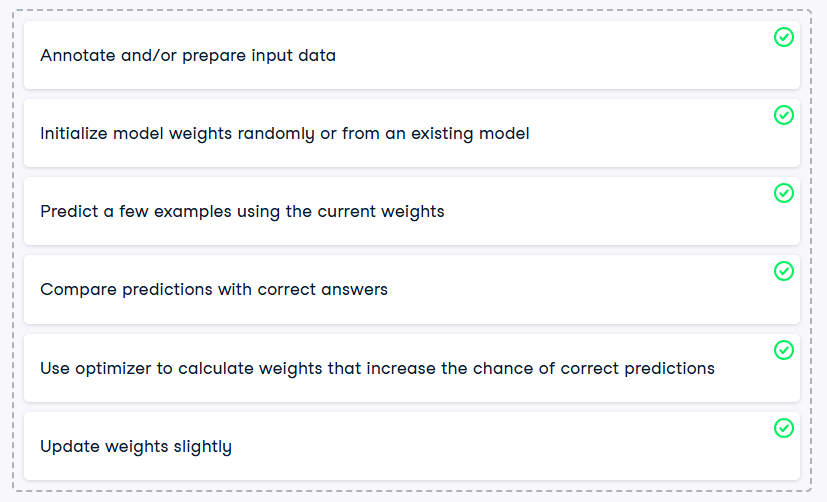

**Annotation and preparing training data**  
After collecting data, you can annotate data in the required format for a spaCy model. In this exercise, you will practice forming the correct annotated data record for an NER task in the medical domain.

A sentence and two entities of entity_1 with a text of chest pain and a SYMPTOM type and entity_2 with a text of hyperthyroidism and a DISEASE type are available for you to use.

In [ ]:
text = "A patient with chest pain had hyperthyroidism."
entity_1 = "chest pain"
entity_2 = "hyperthyroidism"

# Store annotated data information in the correct format
annotated_data = {"sentence": text, "entities": [{"label": "SYMPTOM", "value": entity_1}, {"label": "DISEASE", "value": entity_2}]}

# Extract start and end characters of each entity
entity_1_start_char = text.find(entity_1)
entity_1_end_char = entity_1_start_char + len(entity_1)
entity_2_start_char = text.find(entity_2)
entity_2_end_char = entity_2_start_char + len(entity_2)

# Store the same input information in the proper format for training
training_data = [(text, {"entities": [(entity_1_start_char, entity_1_end_char, "SYMPTOM"),
                                      (entity_2_start_char, entity_2_end_char, "DISEASE")]})]
print(training_data)

# ->  After collecting data, you can annotate data in the required format for a spaCy model. In this instance,
# you successfully completed an annotated data and formatted training data correctly for a NER task.

[('A patient with chest pain had hyperthyroidism.', {'entities': [(15, 25, 'SYMPTOM'), (30, 45, 'DISEASE')]})]


**Compatible training data**  
Recall that you cannot feed the raw text directly to spaCy. Instead, you need to create an Example object for each training example. In this exercise, you will practice converting a training_data with a single annotated sentence into a list of Example objects.

en_core_web_sm model is already imported and ready for use as nlp. The Example class is also imported for your use.

In [ ]:
example_text = 'A patient with chest pain had hyperthyroidism.'
training_data = [(example_text, {'entities': [(15, 25, 'SYMPTOM'), (30, 45, 'DISEASE')]})]

all_examples = []
# Iterate through text and annotations and convert text to a Doc container
for text, annotations in training_data:
  doc = nlp(text)

  # Create an Example object from the doc contianer and annotations
  from spacy.training import Example
  example_sentence = Example.from_dict(doc, annotations)
  print(example_sentence.to_dict(), "\n")

  # Append the Example object to the list of all examples
  all_examples.append(example_sentence)

print("Number of formatted training data: ", len(all_examples))


# You can now convert training data into the proper object that is compatible for use during training of a spaCy model.

{'doc_annotation': {'cats': {}, 'entities': ['O', 'O', 'O', 'B-SYMPTOM', 'L-SYMPTOM', 'O', 'U-DISEASE', 'O'], 'spans': {}, 'links': {}}, 'token_annotation': {'ORTH': ['A', 'patient', 'with', 'chest', 'pain', 'had', 'hyperthyroidism', '.'], 'SPACY': [True, True, True, True, True, True, False, False], 'TAG': ['', '', '', '', '', '', '', ''], 'LEMMA': ['', '', '', '', '', '', '', ''], 'POS': ['', '', '', '', '', '', '', ''], 'MORPH': ['', '', '', '', '', '', '', ''], 'HEAD': [0, 1, 2, 3, 4, 5, 6, 7], 'DEP': ['', '', '', '', '', '', '', ''], 'SENT_START': [1, 0, 0, 0, 0, 0, 0, 0]}} 

Number of formatted training data:  1


### raining with spaCy

**Training preparation steps**  
Before and during training of a spaCy model, you'll need to (1) disable other pipeline components in order to only train the intended component and (2) convert a Doc container of a training data point and its corresponding annotations into an Example class.

In this exercise, you will practice these two steps by using a pre-loaded en_core_web_sm model, which is accessible as nlp. Example class is already imported and a text string and related annotations are also available for your use.

In [ ]:
nlp = spacy.load("en_core_web_sm")

# Disable all pipeline components of  except `ner`
other_pipes = [pipe for pipe in nlp.pipe_names if pipe != 'ner']
nlp.disable_pipes(*other_pipes)

# Convert a text and its annotations to the correct format usable for training
doc = nlp.make_doc(text)
example = Example.from_dict(doc, annotations)
print("Example object for training: \n", example.to_dict())

# You can now disbale pipeline components and convert data into proper spaCy format for training,
# an Example class with multiple keys such as entities and token_annotations.

Example object for training: 
 {'doc_annotation': {'cats': {}, 'entities': ['O', 'O', 'O', 'O', 'U-PERSON', 'O', 'U-GPE', 'O'], 'spans': {}, 'links': {}}, 'token_annotation': {'ORTH': ['I', "'m", 'going', 'to', 'Sam', "'s", 'house', '.'], 'SPACY': [False, True, True, True, False, True, False, False], 'TAG': ['', '', '', '', '', '', '', ''], 'LEMMA': ['', '', '', '', '', '', '', ''], 'POS': ['', '', '', '', '', '', '', ''], 'MORPH': ['', '', '', '', '', '', '', ''], 'HEAD': [0, 1, 2, 3, 4, 5, 6, 7], 'DEP': ['', '', '', '', '', '', '', ''], 'SENT_START': [1, 0, 0, 0, 0, 0, 0, 0]}}


**Train an existing NER model**  
A spaCy model may not work well on a given data. One solution is to train the model on our data. In this exercise, you will practice training a NER model in order to improve its prediction performance.

A spaCy en_core_web_sm model that is accessible as nlp, which is not able to correctly predict house as an entity in a test string.

Given a training_data, write the steps to update this model while iterating through the data two times. The other pipelines are already disabled and optimizer is also ready to be used. Number of epochs is already set to 2.

In [ ]:
import random
nlp = spacy.load("en_core_web_sm")

# Define placeholder variables for test, training_data, and epochs
test = "I'm going to Sam's house."
training_data = [("I'm going to Sam's house.",
  {'entities': [(13, 16, 'PERSON'), (19, 24, 'GPE')]}),
 ('I will visit you in Austin.', {'entities': [(20, 26, 'GPE')]}),
 ('I will go.', {'entities': []})]
epochs = 2

print("Before training: ", [(ent.text, ent.label_) for ent in nlp(test).ents])
other_pipes = [pipe for pipe in nlp.pipe_names if pipe != 'ner']
nlp.disable_pipes(*other_pipes)
optimizer = nlp.create_optimizer()

# Shuffle training data and the dataset using random package per epoch
for i in range(epochs):
  random.shuffle(training_data)
  for text, annotations  in training_data:
    doc = nlp.make_doc(text)
    # Update nlp model after setting sgd argument to optimizer
    from spacy.training import Example
    example = Example.from_dict(doc, annotations)
    nlp.update([example], sgd=optimizer)

print("After training: ", [(ent.text, ent.label_) for ent in nlp(test).ents])

# You just trained an existing spaCy NER model for two epochs. You can see that prior to training,
# the model was unable to predict house as an entity, but training helped with model predictions.

Before training:  [('Sam', 'PERSON')]
After training:  [('Sam', 'PERSON'), ('house', 'GPE')]


**Training a spaCy model from scratch**  
spaCy provides a very clean and efficient approach to train your own models. In this exercise, you will train a NER model from scratch on a real-world corpus (CORD-19 data).

Training data is available in the right format as training_data. In this exercise, you will use a given list of labels ("Pathogen", "MedicalCondition", "Medicine") stored in labels using a blank English model (nlp) with an NER component. Intended medical labels will be added the NER pipeline and then you can train the model for one epoch. You can use pre-imported Example class to convert the training data to the required format. To track model training you can add a losses list to the .update() method and review training loss.

In [ ]:
labels = ['Pathogen', 'MedicalCondition', 'Medicine']

# Load a blank English model, add NER component, add given labels to the ner pipeline
nlp = spacy.blank("en")
ner = nlp.add_pipe("ner")
for ent in labels:
    ner.add_label(ent)

# Disable other pipeline components, complete training loop and run training loop
other_pipes = [pipe for pipe in nlp.pipe_names if pipe != "ner"]
nlp.disable_pipes(*other_pipes)
losses = {}
optimizer = nlp.begin_training()
for text, annotation in training_data:
    doc = nlp.make_doc(text)
    example = Example.from_dict(doc, annotation)
    nlp.update([example], sgd=optimizer, losses=losses)
    print(losses)

# You just trained an NER model from scratch for the medical domain using a subset of CORD-19 data and medical labels to improve NER prediction on a medical data.

{'ner': np.float32(3.7142854)}
{'ner': np.float32(10.221551)}
{'ner': np.float32(17.632662)}
